# Unconditional Diffusion Generation Examples
This notebook shows how diffusion models can be used to generate realistic-looking synthetic imagery. The general workflow holds true for most other diffusion-based tasks such as super-resolution, conditional or text-based generation, and inpainting. The tutorial is inspired by [this repository](https://github.com/mikonvergence/DiffusionFastForward)


## 0. Handle Imports and Data

In [ ]:
!git clone https://github.com/mikonvergence/DiffusionFastForward
!pip install pytorch-lightning==1.9.3 diffusers einops kornia

In [2]:
!cp /content/drive/MyDrive/valencia_share/diffusion_confusion/data/butterflies.zip butterflies.zip

In [3]:
!unzip -o -q butterflies.zip

In [4]:
!mkdir example_images
!mkdir checkpoints

In [5]:
import sys
sys.path.append('./DiffusionFastForward/')

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from PIL import Image
from IPython.display import display
from tqdm import tqdm


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
from skimage import io
import os

from src import *

mpl.rcParams['figure.figsize'] = (8, 8)

### 0.1 Utils

In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio



def forward_step(t, condition_img, return_noise=False):
    """
        forward step: t-1 -> t
    """
    assert t >= 0

    mean=alphas_sqrt[t]*condition_img
    std=betas[t].sqrt()

    # sampling from N
    if not return_noise:
        return mean+std*torch.randn_like(img)
    else:
        noise=torch.randn_like(img)
        return mean+std*noise, noise

def forward_jump(t, condition_img, condition_idx=0, return_noise=False):
    """
        forward jump: 0 -> t
    """
    assert t >= 0

    mean=alphas_cumprod_sqrt[t]*condition_img
    std=(1-alphas_cumprod[t]).sqrt()

    # sampling from N
    if not return_noise:
        return mean+std*torch.randn_like(img)
    else:
        noise=torch.randn_like(img)
        return mean+std*noise, noise

def input_T(input):
    # [0,1] -> [-1,+1]
    return 2*input-1

def output_T(input):
    # [-1,+1] -> [0,1]
    return (input+1)/2

def show(input):
    plt.imshow(output_T(input).clip(0,1))









In [36]:
def show_noise_schedule():
  #from src import *

  D=128
  make_white=False
  save=False
  line_color='black' #'#9EFFB9'
  test_img=img_

  for schedule in ['sigmoid']:#,'quadratic','sigmoid','cosine']:
      fw=GaussianForwardProcess(1000,
                                schedule)

      plt.figure(figsize=(10,2))
      plt.subplot(1,6,1)
      plt.plot(fw.betas,color=line_color)
      plt.title(schedule,color=line_color)
      plt.xlabel(r'step $t$',color=line_color)
      plt.ylabel(r'$\beta_t$',color=line_color)

      if make_white:
          plt.xticks(color='white')
          plt.gca().tick_params(axis='x', colors='white')
          plt.gca().tick_params(axis='y', colors='white')
          plt.gca().spines['top'].set_color('white')
          plt.gca().spines['right'].set_color('white')
          plt.gca().spines['left'].set_color('white')
          plt.gca().spines['bottom'].set_color('white')
      for step in range(5):
          plt.subplot(1,6,step+2)
          plt.imshow(fw(test_img.permute(2,0,1).unsqueeze(0),torch.tensor(step*200))[0].permute(1,2,0))
          plt.axis('off')
      plt.tight_layout()


      if save:
          plt.savefig('{}.png'.format(schedule),
                      dpi=200,
                      bbox_inches='tight',
                      pad_inches=0.0,
                      transparent=True)

In [20]:
def show_1_step():
  t_step=50

  x_t,noise=forward_jump(t_step,img_,return_noise=True)

  plt.subplot(1,3,1)
  show(img_)
  plt.title(r'$x_0$')
  plt.axis('off')
  plt.subplot(1,3,2)
  show(x_t)
  plt.title(r'$x_t$')
  plt.axis('off')
  plt.subplot(1,3,3)
  show(noise)
  plt.title(r'$\epsilon$')
  plt.axis('off')

# 1.1 Data Functions

In [7]:
# Define the Dataset
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path,target_size=64):
        self.folder_path,self.target_size = folder_path,target_size
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = T.ToTensor()
        #self.image_files = self.image_files[:100]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        image = image.resize((self.target_size,self.target_size), Image.BILINEAR)
        image = self.transform(image)
        return image

class ValDataset(Dataset):
    def __init__(self):
      pass
    def __len__(self):
      return(1)
    def __getitem__(self,idx):
      return {}


# Create the dataset
folder_path = "/content/test"
dataset_train = ImageFolderDataset(folder_path)
dataset_val = ValDataset()
sample_batch = dataset_train.__getitem__(100).unsqueeze(0)

print(f"Dataset Instanciated with {len(dataset_train)} images.")

Dataset Instanciated with 2786 images.


# 2. Investigating Functions and Components
### 2.1 Looking at data

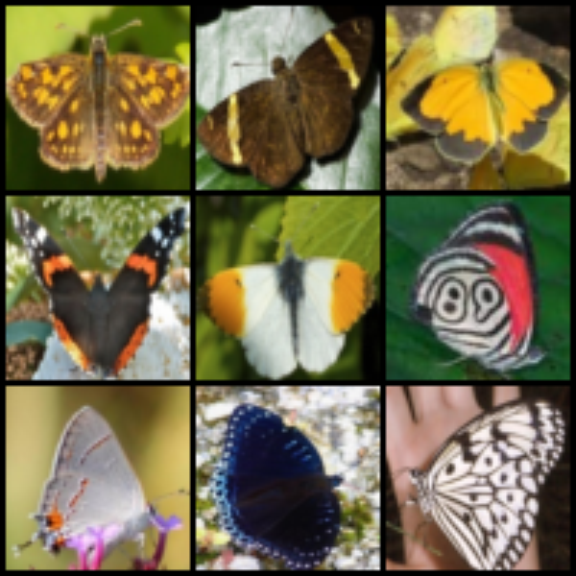

In [13]:
def plot_grid(dataset,nrow=2):
    assert nrow in [1,2,3], "nrow must be in 1,2,3. Otherwise will take too long"
    from torchvision.utils import make_grid
    from torchvision.transforms import ToPILImage

    # generate Images with DDPM
    b = nrow**2
    images = []
    for i in range(b):
        images.append(dataset.__getitem__(i))
    images = torch.stack(images)

    # Create a 3x3 grid of the generated images
    image_grid = make_grid(images, nrow=nrow)
    pil_image = ToPILImage()(image_grid)
    pil_image = pil_image.resize((nrow*64*3,nrow*64*3), Image.BILINEAR) # make image larger
    return(pil_image)

display(plot_grid(dataset_train,nrow=3))

### 2.2 Tracing Forward Step

In [ ]:
# Instanciate Model
model=PixelDiffusion(train_dataset=dataset_train,
                     valid_dataset=dataset_val,
                     num_timesteps=1000,
                     lr=1e-4,
                     batch_size=24)
model = model.cuda()



```
def forward(self,
                shape=(256,256),
                batch_size=1,
                sampler=None,
                verbose=False
               ):
        """
            forward() function triggers a complete inference cycle
            
            A custom sampler can be provided as an argument!
        """           
        
        # read dimensions
        b,c,h,w=batch_size,self.generated_channels,*shape
        device=next(self.model.parameters()).device
        
        # select sampler
        if sampler is None:
            sampler=self.sampler
        else:
            sampler.to(device)

        # time steps list
        num_timesteps=sampler.num_timesteps
        it=reversed(range(0, num_timesteps))    
        
        x_t = torch.randn([b, self.generated_channels, h, w],device=device) # random conditioning
                
        for i in tqdm(it, desc='diffusion sampling', total=num_timesteps):
            t = torch.full((b,), i, device=device, dtype=torch.long)
            z_t=self.model(x_t,t) # prediction of noise
            x_t = sampler(x_t,t,z_t) # prediction of next state
            
        return x_t```



lets try out all the functionalities

In [64]:
# whole forward function
out = model.model.forward(shape=(16,16),verbose=True)
print(out.shape)

diffusion sampling:   0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([1, 3, 16, 16])


In [36]:
# Conditioning Tensor
# b,c,h,w=batch_size,self.generated_channels,*shape
b = 1 # batches
c = 3 # Channels
h,w = 128,128
x_t = torch.randn([b, c, h, w])
print("Shape, Min, Mean, Max\n",x_t.shape,x_t.min().item(),x_t.mean(),x_t.max())

Shape, Min, Mean, Max
 torch.Size([1, 3, 128, 128]) -3.946488618850708 tensor(0.0043) tensor(3.9136)


In [38]:
print("No. of Timesteps:",model.model.num_timesteps)
print("Timesteps:\n",*reversed(range(0, model.model.num_timesteps)))

No. of Timesteps: 1000
Timesteps:
 999 998 997 996 995 994 993 992 991 990 989 988 987 986 985 984 983 982 981 980 979 978 977 976 975 974 973 972 971 970 969 968 967 966 965 964 963 962 961 960 959 958 957 956 955 954 953 952 951 950 949 948 947 946 945 944 943 942 941 940 939 938 937 936 935 934 933 932 931 930 929 928 927 926 925 924 923 922 921 920 919 918 917 916 915 914 913 912 911 910 909 908 907 906 905 904 903 902 901 900 899 898 897 896 895 894 893 892 891 890 889 888 887 886 885 884 883 882 881 880 879 878 877 876 875 874 873 872 871 870 869 868 867 866 865 864 863 862 861 860 859 858 857 856 855 854 853 852 851 850 849 848 847 846 845 844 843 842 841 840 839 838 837 836 835 834 833 832 831 830 829 828 827 826 825 824 823 822 821 820 819 818 817 816 815 814 813 812 811 810 809 808 807 806 805 804 803 802 801 800 799 798 797 796 795 794 793 792 791 790 789 788 787 786 785 784 783 782 781 780 779 778 777 776 775 774 773 772 771 770 769 768 767 766 765 764 763 762 761 760 759 7

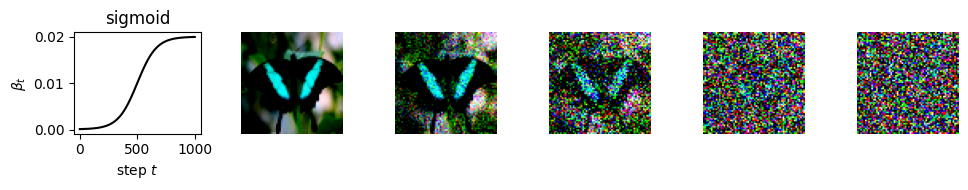

In [39]:
show_noise_schedule()

In [54]:
# Testing prediction Step
# t = torch.full((b,), i, device=device, dtype=torch.long)
# z_t=self.model(x_t,t)

# 1. Prediction Step
x_t = torch.rand(1,3,64,64).cuda() # create conditioning
t   = torch.full((1,), 499).cuda() # create timestep info
z_t = model.model.model.forward(x_t,t) # prediction of noise

print("Timestep:",t,"\nOutput Shape:",z_t.shape)

Timestep: tensor([499], device='cuda:0') 
Output Shape: torch.Size([1, 3, 64, 64])


In [57]:
# x_t = sampler(x_t,t,z_t)
# 2. Sampler Step
x_t = model.model.sampler(x_t,t,z_t) # subtract the predicted noise (z_t) from x_t
print(x_t.shape)

# loop continues

torch.Size([1, 3, 64, 64])


### 2.3 Tracing Training Step



```
    def training_step(self, batch, batch_idx):   
        images=batch
        loss = self.model.p_loss(self.input_T(images))
        
        self.log('train_loss',loss)
        
        return loss
```





```
    def p_loss(self,output):
        """
            Assumes output is in [-1,+1] range
        """        
        
        b,c,h,w=output.shape
        device=output.device
        
        # loss for training
        
        # input is the optional condition
        t = torch.randint(0, self.forward_process.num_timesteps, (b,), device=device).long()
        output_noisy, noise=self.forward_process(output,t,return_noise=True)        

        # reverse pass
        noise_hat = self.model(output_noisy, t)

        # apply loss
        return self.loss_fn(noise, noise_hat)
```



In [69]:
t = torch.randint(0, model.model.forward_process.num_timesteps, (1,), ).long()
print(t)

tensor([160])


noisy tensor at t 27


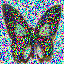

Noise


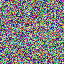

In [103]:
# Check the creation of the noisy image and target
t = torch.randint(26, 28, (1,), ).long() # Get a low T so that we can see the image
output_noisy, noise=model.model.forward_process(sample_batch.cuda(),t,return_noise=True)

# look at output
print("noisy tensor at t",t.item())
tensor = output_noisy[0].cpu().permute(1, 2, 0).numpy()
tensor = (tensor * 255).astype(np.uint8)
image = Image.fromarray(tensor)
display(image)

print("Noise")
tensor = noise[0].cpu().permute(1, 2, 0).numpy()
tensor = (tensor * 255).astype(np.uint8)
image = Image.fromarray(tensor)
display(image)

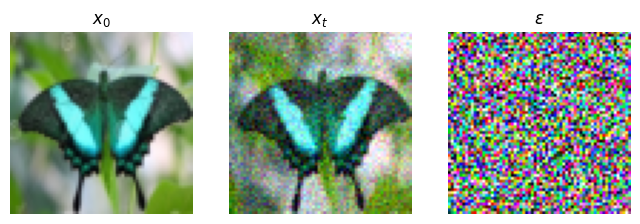

In [23]:
show_1_step()

# 3. Model and Training
### 3.1 Prepare Model


In [ ]:
# define custom PL funciton to save images
def custom_on_validation_epoch_end(self,nrow = 2):
    assert nrow in [1,2,3], "nrow must be in 1,2,3. Otherwise will take too long"

    import os,torch
    from torchvision.utils import make_grid, save_image

    # generate Images with DDPM
    batch_size = nrow**2
    generated_images_tensor = self.model(batch_size=batch_size,shape=(64,64),verbose=True)

    # Create a 3x3 grid of the generated images
    image_grid = make_grid(generated_images_tensor, nrow=nrow)

    # Ensure the 'images' folder exists
    os.makedirs("images", exist_ok=True)

    # Save the grid of images as 'epoch_n.png'
    current_epoch = self.current_epoch+1
    file_path = f"example_images/epoch_{current_epoch:03}.png"
    save_image(image_grid, file_path)

    print(f"Saved generated image grid for epoch {current_epoch} at {file_path}")

def create_grid(self,nrow=2):
    assert nrow in [1,2,3], "nrow must be in 1,2,3. Otherwise will take too long"
    from torchvision.utils import make_grid
    from torchvision.transforms import ToPILImage

    # generate Images with DDPM
    b = nrow**2
    generated_images_tensor = self.model(batch_size=b,shape=(64,64),verbose=True)

    # Create a 3x3 grid of the generated images
    image_grid = make_grid(generated_images_tensor, nrow=nrow)
    pil_image = ToPILImage()(image_grid)
    pil_image = pil_image.resize((nrow*64*3,nrow*64*3), Image.BILINEAR) # make image larger
    return(pil_image)


def custom_validation_step(self, batch, batch_idx):
    pass


In [ ]:
# Model Saving Callback
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer

# Define the callback
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",    # Directory to save the model checkpoints
    filename="model-{epoch}", # Filename template (epoch number will be appended)
    save_top_k=-1,             # S
    every_n_epochs=10         # Save the model after every n epoch
)

In [ ]:
# Instanciate Model
model=PixelDiffusion(train_dataset=dataset_train,
                     valid_dataset=dataset_val,
                     num_timesteps=500,
                     lr=1e-4,
                     batch_size=24)

# Set image saving funciton
model.on_validation_epoch_end = custom_on_validation_epoch_end.__get__(model)
model.validation_step = custom_validation_step.__get__(model)

# Save create Grid Function
model.create_grid = create_grid.__get__(model)
model = model.to("cuda")

# prepare PL trainer
trainer = pl.Trainer(
    max_epochs=250,
    check_val_every_n_epoch=10,
    callbacks=[EMA(0.9999),
               checkpoint_callback],
    gpus = [0]
)

Is Time embed used ?  True


/content/./DiffusionFastForward/src/EMA.py:58: UserWarning: EMA has better performance when Apex is installed: https://github.com/NVIDIA/apex#installation.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### 3.2 Train Model

In [ ]:
trainer.fit(model)

#3. Inference

In [ ]:
for i in range(10):
  img = model.create_grid(nrow=3)
  display(img)

Epoch: 50


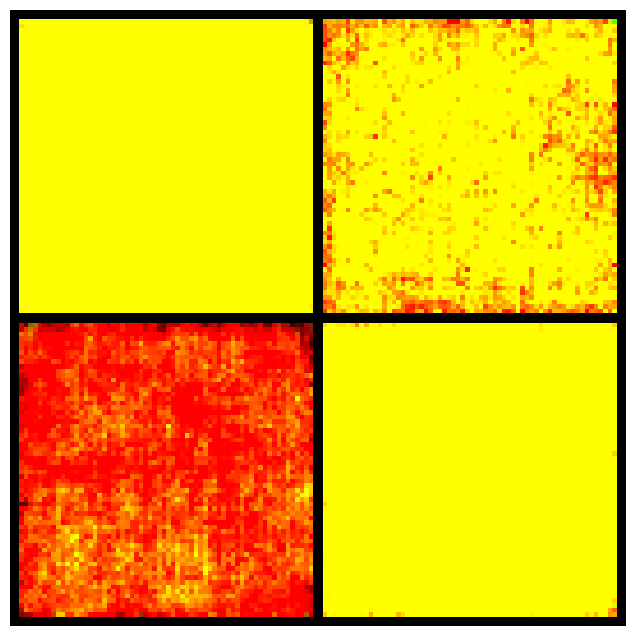

Epoch: 100


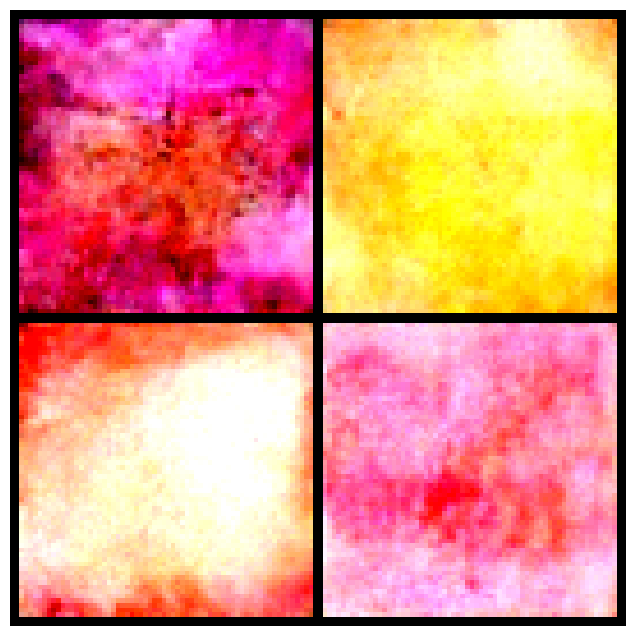

Epoch: 500


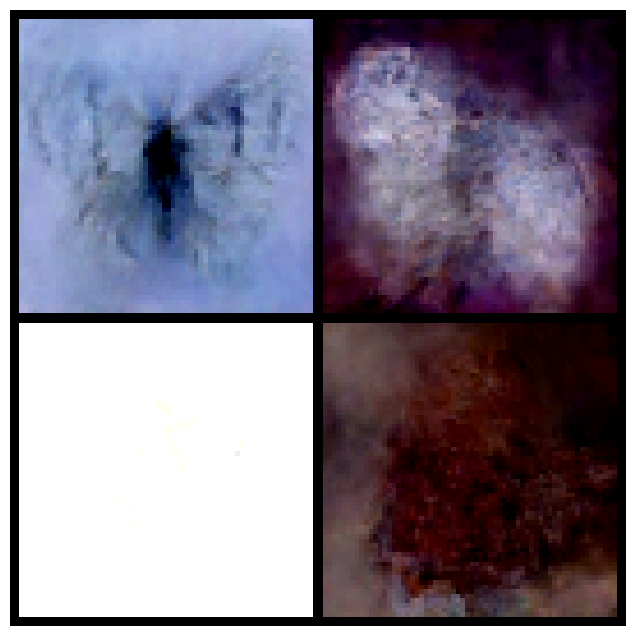

Epoch: 750


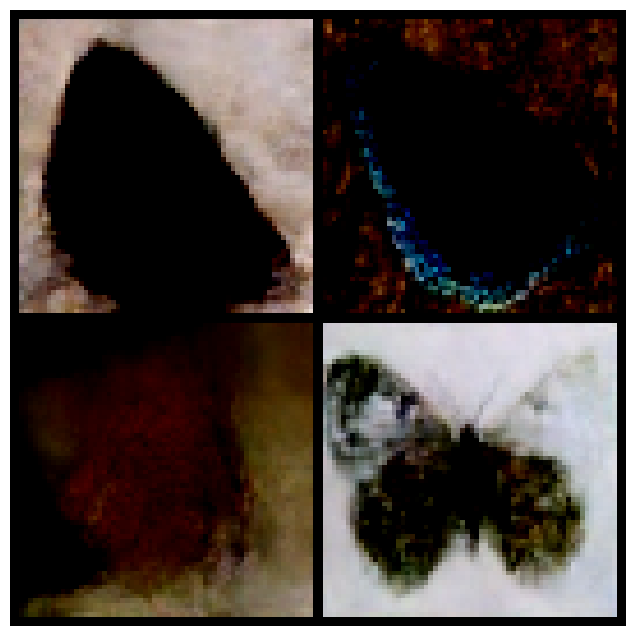

Epoch: 1000


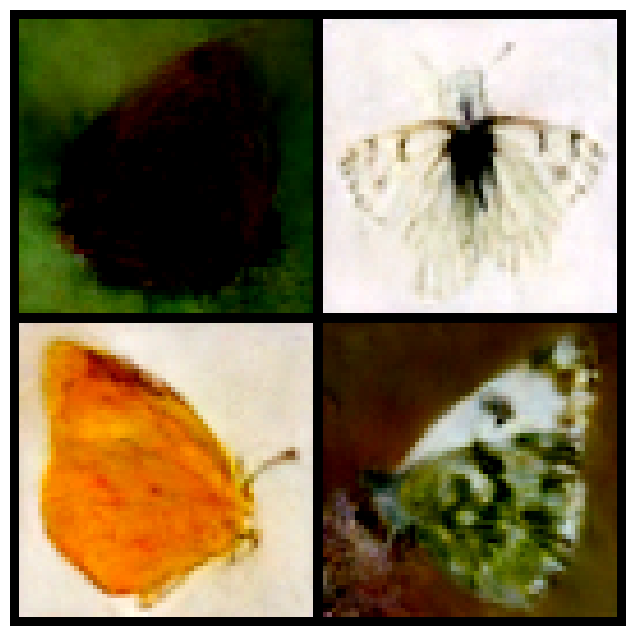

In [109]:
images = ["https://github.com/simon-donike/diffusion_confusion/blob/master/result_images/epoch_050.png?raw=true",
          "https://github.com/simon-donike/diffusion_confusion/blob/master/result_images/epoch_100.png?raw=true",
          "https://github.com/simon-donike/diffusion_confusion/blob/master/result_images/epoch_500.png?raw=true",
          "https://github.com/simon-donike/diffusion_confusion/blob/master/result_images/epoch_750.png?raw=true",
          "https://github.com/simon-donike/diffusion_confusion/blob/master/result_images/epoch_1000.png?raw=true"]
eps = [50,100,500,750,1000
       ]
# Display each image
import requests
from io import BytesIO
for ep,img_url in zip(eps,images):
    print("Epoch:",ep)
    response = requests.get(img_url)  # Fetch image from URL
    img = Image.open(BytesIO(response.content))  # Open the image with PIL

    # Show the image using matplotlib
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    plt.show()